<a href="https://colab.research.google.com/github/Valaybundele/Stable-Prototypical-Networks/blob/main/SPN_Salinas_5_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install spectral

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import random
from tensorflow.keras import Sequential,layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import statistics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import tensorflow_probability as tfp
from operator import truediv
from tensorflow.compat.v1.distributions import Bernoulli
from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import tensorflow as tf
from tensorflow.python.keras import backend as K

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
# Global variables
im_width, im_height, im_depth, im_channel = 11,11,30,1
mc_loss_weight = 5

## Model Construction

In [ ]:
def calc_euclidian_dists(x, y):
  # x : (n,d)
  # y : (m,d)
    n = x.shape[0]
    m = y.shape[0]
    x = tf.tile(tf.expand_dims(x, 1), [1, m, 1])
    y = tf.tile(tf.expand_dims(y, 0), [n, 1, 1])
    return tf.reduce_mean(tf.math.pow(x - y, 2), 2)

In [ ]:
def _bernoulli(shape, mean):
    return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))

In [ ]:
class DropBlock3D(tf.keras.layers.Layer):
    def __init__(self, keep_prob, block_size, scale=True, **kwargs):
        super(DropBlock3D, self).__init__(**kwargs)
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
        self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale

    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        assert len(input_shape) == 5
        _, self.d, self.h, self.w, self.channel = input_shape.as_list()
        # pad the mask
        p0 = (self.block_size - 1) // 2
        p1 = (self.block_size - 1) - p0
        self.padding = [[0, 0], [p0, p1], [p0, p1], [p0, p1], [0, 0]]
        self.set_keep_prob()
        super(DropBlock3D, self).build(input_shape)

    def call(self, inputs, training=True, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            output = inputs * mask
            output = tf.cond(self.scale,
                             true_fn=lambda: output * tf.compat.v1.to_float(tf.size(mask)) / tf.reduce_sum(mask),
                             false_fn=lambda: output)
            return output

        if training is None:
            training = K.learning_phase()
        output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        d, w, h = tf.compat.v1.to_float(self.d), tf.compat.v1.to_float(self.w), tf.compat.v1.to_float(self.h)
        self.gamma = ((1. - self.keep_prob) * (d * w * h) / (self.block_size ** 3) /
                      ((d - self.block_size + 1) * (w - self.block_size + 1) * (h - self.block_size + 1)))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                        self.d - self.block_size + 1,
                                        self.h - self.block_size + 1,
                                        self.w - self.block_size + 1,
                                        self.channel])
        mask = _bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool3d(mask, [1, self.block_size, self.block_size, self.block_size, 1], [1, 1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask

In [ ]:
input_layer = layers.Input(shape = (im_height, im_width, im_depth, im_channel))
out1 = layers.Conv3D(filters=8, kernel_size=(3,3,7), activation='relu',input_shape=(im_height, im_width, im_depth, im_channel),padding='same')(input_layer)
out1 = DropBlock3D(0.7,3)(out1)
out2 = layers.Conv3D(filters=16, kernel_size=(3,3,5), activation='relu',padding='same')(out1)
out2 = DropBlock3D(0.7,3)(out2)
out3 = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation= 'relu')(out2)
out3 = layers.Reshape((out3.shape[1], out3.shape[2], out3.shape[3]*out3.shape[4]))(out3)
out3 = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(out3)
out4 = layers.Flatten()(out3)
out4 = layers.Dropout(0.4)(out4, training=True)
out4 = layers.Dense(256, activation='relu')(out4)
out5 = layers.Dropout(0.4)(out4,training=True)
out5 = layers.Dense(128, activation='relu')(out5)
model = Model(inputs=input_layer,outputs=out5)
model.summary()

Instructions for updating:
Use `tf.cast` instead.
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 11, 30, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 11, 11, 30, 8)     512       
_________________________________________________________________
drop_block3d (DropBlock3D)   (None, 11, 11, 30, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 11, 30, 16)    5776      
_________________________________________________________________
drop_block3d_1 (DropBlock3D) (None, 11, 11, 30, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 9, 9, 28, 32)      13856     
_________________________________________________________________
resh

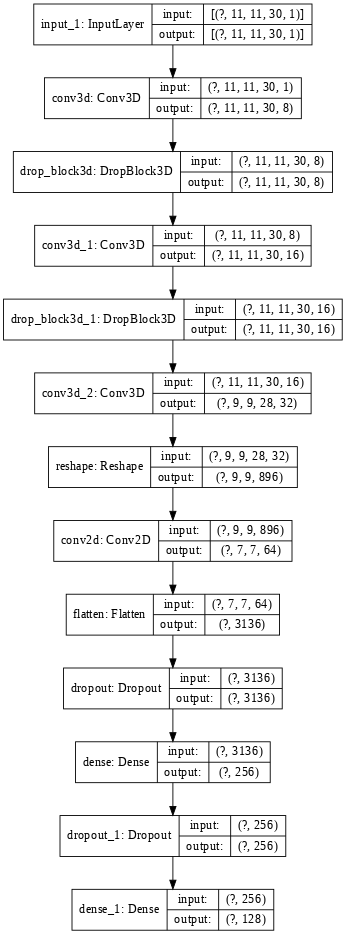

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64,to_file='Hyper_Proto.png',expand_nested=False)

In [ ]:
class Prototypical(Model):
    def __init__(self, model, w, h, d, c):
        super(Prototypical, self).__init__()
        self.w, self.h, self.d, self.c = w, h, d, c
        self.encoder = model

    def call(self, support, query, support_labels, query_labels, K, C, N,n_times,training=True):
      n_class = C                                                               #10
      n_support = K                                                             #5
      n_query = N                                                               #15 

      if training == True : 
        loss = 0
        mc_predictions = []                                                     # list of predictions for multiple passes
        for i in range(n_times) :                                               # n_times passing every query image for calculating variance
          y = np.zeros((int(C*N),C))                                            #(150,10)
          for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for true labels
            y[i][x] = 1.                                                 
          cat = tf.concat([support,query], axis=0)                              # [200,9,9,20,1])   
          z = self.encoder(cat)                                                 # [200,320]
          # Divide embedding into support and query
          z_prototypes = tf.reshape(z[:n_class * n_support],[n_class, n_support, z.shape[-1]])   #[10, 5, 320])
          # Prototypes are means of n_support examples
          z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)              #[10,320]
          z_query = z[n_class * n_support:]                                     #[150,320]                         
          # Calculate distances between query and prototypes
          dists = calc_euclidian_dists(z_query, z_prototypes)                   #[150,10]
          # log softmax of calculated distances
          log_p_y = tf.nn.log_softmax(-dists, axis=-1)                          #[150,10]        
          loss1 = -tf.reduce_mean((tf.reduce_sum(tf.multiply(y, log_p_y), axis=-1)))   #loss for the current pass                     
          loss += loss1                                                                # adding loss for each pass                   
          predictions = tf.nn.softmax(-dists, axis=-1)                                 # prediction probability for the search-space classes per query image(for current pass)
          mc_predictions.append(predictions)                                          

        y = np.zeros((int(C*N),C))
        for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for true labels
            y[i][x] = 1. 
        mc_predictions = tf.convert_to_tensor(np.reshape(np.asarray(mc_predictions),(n_times,int(C*N),C)))  #(n_times,150,10)
        std_predictions = tf.math.reduce_std(mc_predictions,axis=0)
        std = tf.reduce_sum(tf.reduce_sum(tf.multiply(std_predictions,y),axis=1))
        loss += mc_loss_weight*std
        # calculating mean accuracy
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (150,10)
        mean_eq = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(mean_predictions, axis=-1), tf.int32), 
            tf.cast(tf.argmax(y,axis=-1), tf.int32)), tf.float32)
        mean_accuracy = tf.reduce_mean(mean_eq)
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (150,10)
        return loss, mean_accuracy, mean_predictions   
      
      if training == False :
        loss = 0
        mc_predictions = []                                                     # list of predictions for multiple passes  
        for i in range(n_times) :                                               # n_times passing the query images for variance calculation
          y = np.zeros((int(C*N),C))                                            # (150,10)
          for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.  
          # merge support and query to forward through encoder
          cat = tf.concat([support,query], axis=0)                              # [200,9,9,20,1]   
          z = self.encoder(cat)                                                 # [200, 320]
          # Divide embedding into support and query
          z_prototypes = tf.reshape(z[:n_class * n_support],[n_class, n_support, z.shape[-1]])   #[10, 5, 320])
          # Prototypes are means of n_support examples
          z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)              #[10, 320]
          z_query = z[n_class * n_support:]                                     #[150, 320]                         
          # Calculate distances between query and prototypes
          dists = calc_euclidian_dists(z_query, z_prototypes)                   #[150, 10]
          # log softmax of calculated distances
          log_p_y = tf.nn.log_softmax(-dists, axis=-1)                          #[150, 10]        
          loss1 = -tf.reduce_mean((tf.reduce_sum(tf.multiply(y, log_p_y), axis=-1)))        
          loss += loss1
          predictions = tf.nn.softmax(-dists, axis=-1)                                 # prediction probabilities for the classes for current pass
          mc_predictions.append(predictions)                                             
        y = np.zeros((int(C*N),C))                                            # (150,10)
        for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.  
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (150,10)
        mean_eq = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(mean_predictions, axis=-1), tf.int32), 
            tf.cast(tf.argmax(y,axis=-1), tf.int32)), tf.float32)
        mean_accuracy = tf.reduce_mean(mean_eq)
        mean_pred_index = tf.argmax(mean_predictions,axis=1)
        # mean class-wise accuracies
        mean_correct_class = [[] for i in range(tC)]
        mean_correct_pred = [[] for i in range(tC)]
        classwise_mean_acc = [[] for i in range(tC)]
        for i in range(int(C*N)):
          x = support_labels.index(query_labels[i])
          mean_correct_class[x].append('4')
          if(mean_pred_index[i] == x) :
            mean_correct_pred[x].append('4')
        for i in range(tC) :
           z = len(mean_correct_pred[i])/len(mean_correct_class[i])
           classwise_mean_acc[i].append(z)  
        #std calculation
        std = 0
        for i in range(int(C*N)) :
           x = support_labels.index(query_labels[i])
           p_i = np.array([p[i,:] for p in mc_predictions])
           std_i = tf.math.reduce_std(p_i,axis=0) 
           std_i_true = std_i[x]
           std += std_i_true                                                    # adding std of each class
        loss += mc_loss_weight*std 
        y = np.zeros((int(C*N),C))                                            # (150,10)
        for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.                                                                
        return loss, mc_predictions, mean_accuracy, classwise_mean_acc, y


      def save(self, model_path):
        self.encoder.save(model_path)

      def load(self, model_path):
        self.encoder(tf.zeros([1, self.w, self.h, self.c]))
        self.encoder.load_weights(model_path)

## Data Loading

In [ ]:
def loadData(name):
    if name == 'IP':
        data = sio.loadmat('/content/drive/My Drive/Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = sio.loadmat('/content/drive/My Drive/Indian_pines_gt.mat')['indian_pines_gt']
    if name == 'salinas' :
        data = sio.loadmat('/content/drive/My Drive/Hyperspectral Few Shot/Hyperspectral datasets/Salinas_corrected.mat')['salinas_corrected']
        labels = sio.loadmat('/content/drive/My Drive/Hyperspectral Few Shot/Hyperspectral datasets/Salinas_gt.mat')['salinas_gt']
    if name == 'pavia' :
        data = sio.loadmat('/content/drive/My Drive/PaviaU.mat')['paviaU']
        labels = sio.loadmat('/content/drive/My Drive/PaviaU_gt.mat')['paviaU_gt']
    if name == 'ksc' :
        data = sio.loadmat('/content/drive/My Drive/KSC.mat')['KSC']
        labels = sio.loadmat('/content/drive/My Drive/KSC_gt.mat')['KSC_gt']
    if name == 'botswana' :
        data = sio.loadmat('/content/drive/My Drive/Botswana.mat')['Botswana']
        labels = sio.loadmat('/content/drive/My Drive/Botswana_gt.mat')['Botswana_gt']

    return data, labels
# without reduction of 200 channels to 30 channels, memory error while creating cube 
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)  # X :(145, 145, 30) --> (195, 195, 30) with window =25
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))  # (21025, 25, 25, 30)   
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))  # (21025,)
    patchIndex = 0
    
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]  
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]            
            patchIndex = patchIndex + 1
  
    patchesData = np.expand_dims(patchesData, axis=-1)
    return patchesData,patchesLabels

In [ ]:
dataset1 = 'salinas'                                         # 16 classes   
sa_x1, sa_y = loadData(dataset1)                              #((512, 217, 204), (512, 217))
sa_x2,pca = applyPCA(sa_x1,numComponents=30)                   # ((512, 217, 20), (512, 217))
sa_X,sa_Y = createImageCubes(sa_x2, sa_y, windowSize=11)   #(111104, 9, 9, 20, 1) (111104,)
print(sa_X.shape,sa_Y.shape)

(111104, 11, 11, 30, 1) (111104,)


In [ ]:
print(sa_x1.shape)
print(sa_y.shape)

(512, 217, 204)
(512, 217)


In [ ]:
def patches_class(X,Y,n) :
  n_classes = n
  patches_list = []
  for i in range(1,n_classes+1):   # not considering class 0
    patchesData_Ith_Label = X[Y==i,:,:,:,:]
    patches_list.append(patchesData_Ith_Label)
  return patches_list 

In [ ]:
patches_class_salinas = patches_class(sa_X,sa_Y,16) # class_wise list of patches #(16,) for class 0: (2009, 9, 9, 20, 1)

In [ ]:
patches_class_salinas[0].shape

(2009, 11, 11, 30, 1)

In [ ]:
train_class_indices = [0,1,2,3,4,5,6,7,8,11]
test_class_indices = [9,10,12,13,14,15]
train_patches_class = [patches_class_salinas[i] for i in train_class_indices]        #(10)
test_patches_class = [patches_class_salinas[i] for i in test_class_indices]        #(6) 
train_class_labels = [1,2,3,4,5,6,7,8,9,12]   
test_class_labels = [10,11,13,14,15,16]    #[11...16]

In [ ]:
print(len(train_patches_class))
print(train_patches_class[1].shape)
print(len(test_patches_class))
print(train_class_labels)
print(test_class_labels)

10
(3726, 11, 11, 30, 1)
6
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12]
[10, 11, 13, 14, 15, 16]


**Prepare Training and validation Dataset**

In [ ]:
C = 5  # n_class
K1 = 5   # n_support
N = 15   # n_query
tC = 3   # classes in a test episode
im_height,im_width,im_depth = 11,11,30

In [ ]:
def new_episode(patches_list,K,C,N,class_labels) :
  selected_classes = np.random.choice(class_labels,C,replace=False)  # Randomly choice 5 Classes out of classes available
  tsupport_patches = []
  tquery_patches = []
  query_labels = []
  support_labels = list(selected_classes)
  for x in selected_classes :
    sran_indices = np.random.choice(len(patches_list[x-1]),K,replace=False)  # for class no X-1: select random sample no
    support_patches = patches_list[x-1][sran_indices,:,:,:,:]
    qran_indices = np.random.choice(len(patches_list[x-1]),N,replace=False)  # N Samples for Query
    query_patches = patches_list[x-1][qran_indices,:,:,:,:]
  # Support and Query patches belong to same Class 
    for i in range(N) :
      query_labels.append(x)    # N Samples for Query
    tquery_patches.extend(query_patches)
    tsupport_patches.extend(support_patches)
  temp1 = list(zip(tquery_patches, query_labels)) 
  random.shuffle(temp1)        # By Doing Shuffling, Support, Query Same class combination got mismatched - mitigated by support index
  tquery_patches, query_labels = zip(*temp1)
  tquery_patches = tf.convert_to_tensor(np.reshape(np.asarray(tquery_patches),(C*N,im_height,im_width,im_depth,1)),dtype=tf.float32)
  tsupport_patches = tf.convert_to_tensor(np.reshape(np.asarray(tsupport_patches),(C*K,im_height,im_width,im_depth,1)),dtype=tf.float32)
  return tquery_patches, tsupport_patches, query_labels, support_labels    

In [ ]:
tquery_patches, tsupport_patches, query_labels, support_labels = new_episode(patches_class_salinas,K1,C,N,train_class_labels)

In [ ]:
print(tsupport_patches.shape) #C*K
print(len(support_labels))# C   
print(support_labels)   
print(tquery_patches.shape)  #C*N  
print(len(query_labels))  # C*N
print(query_labels)

(25, 11, 11, 30, 1)
5
[9, 7, 4, 5, 6]
(75, 11, 11, 30, 1)
75
(6, 6, 9, 9, 7, 7, 7, 7, 5, 5, 7, 4, 5, 6, 4, 7, 6, 4, 9, 4, 6, 5, 5, 7, 6, 7, 5, 5, 5, 5, 4, 6, 6, 9, 9, 7, 9, 9, 5, 6, 4, 4, 7, 9, 7, 4, 6, 4, 7, 7, 9, 4, 9, 5, 7, 7, 5, 4, 5, 6, 9, 4, 9, 6, 9, 4, 6, 4, 9, 5, 5, 6, 6, 4, 9)



## Training

In [ ]:
ProtoModel = Prototypical(model,im_width, im_height, im_depth, im_channel)
optimizer = tf.keras.optimizers.Adam(0.00001)          #Adam(0.001)
n_times = 20
time_list = []

In [ ]:
# Metrics to gather
train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')

def train_step(support, query, support_labels, query_labels, K, C, N):
    # Forward & update gradients
    with tf.GradientTape() as tape:
        loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, K, C, N,n_times,training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log loss and accuracy for step
    train_loss(loss)
    train_acc(mean_accuracy)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Hyperspectral Few Shot/Model checkpoints/vary_N_times/Salinas/20_times/training/ckpts'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 ProtoModel = ProtoModel)

In [ ]:
n_episodes = 100
import time
start = time.clock() 
for epoch in range(121): # n_epochs-0 train
    train_loss.reset_states()  
    train_acc.reset_states()
    
    for epi in range(n_episodes): 
        tquery_patches, tsupport_patches, query_labels, support_labels = new_episode(patches_class_salinas,K1,C,N,train_class_labels)     
        train_step(tsupport_patches, tquery_patches,support_labels, query_labels, K1, C, N)    
    template = 'Epoch {}, Train Loss: {:.2f}, Train Accuracy: {:.2f}'
    print(template.format(epoch+1,train_loss.result(),train_acc.result()*100))
    if epoch % 20 == 0 and epoch != 0 :
        checkpoint.save(file_prefix = checkpoint_prefix)
        final = time.clock()
        time_list.append(final-start+19081.1512)
        time_list = np.asarray(time_list)
        np.save('/content/drive/MyDrive/Hyperspectral Few Shot/Model checkpoints/vary_N_times/Salinas/20_times/training/time/'+ str((epoch/20)+4)+'s_time_list.npy',time_list)
        time_list = time_list.tolist()

In [ ]:
checkpoint.restore('/content/drive/MyDrive/Hyperspectral Few Shot/Model checkpoints/vary_N_times/Salinas/20_times/training/ckpts/ckpt-10')
time_list = np.load('/content/drive/MyDrive/Hyperspectral Few Shot/Model checkpoints/vary_N_times/Salinas/20_times/training/time/10.0s_time_list.npy',allow_pickle=True)
time_list = time_list.tolist()

**Testing**

In [ ]:
print(len(test_patches_class))
print(test_class_labels)

6
[10, 11, 13, 14, 15, 16]


In [ ]:
tune_set_5 = [[] for i in range(6)]
for j in range(6) :
  tune_set_5[j] = test_patches_class[j][:5,:,:,:,:]   # for each class first 5 samples taken
std_tune_5 = []

In [ ]:
print(len(tune_set_5))
print(tune_set_5[0].shape)

6
(5, 11, 11, 30, 1)


In [ ]:
def tune_episode(tune_set,tC,tK,tN,test_class_labels) :
  selected_classes = np.random.choice(test_class_labels,tC,replace=False)
  support_labels  = list(selected_classes)
  query_labels = []
  support_patches = []
  query_patches = []
  for x in selected_classes :
    y = test_class_labels.index(x)
    np.random.shuffle(tune_set[y])    
    support_imgs = tune_set[y][:tK,:,:,:,:]    #Support 1, Query 4
    query_imgs = tune_set[y][tK:5,:,:,:,:]
    support_patches.extend(support_imgs)
    query_patches.extend(query_imgs)
    for i in range(tN) :
      query_labels.append(x)
  temp1 = list(zip(query_patches, query_labels)) 
  random.shuffle(temp1) 
  query_patches, query_labels = zip(*temp1)
  query_patches = tf.convert_to_tensor(np.reshape(np.asarray(query_patches),(tC*tN,im_height,im_width,im_depth,1)),dtype=tf.float32)
  support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(tC*tK,im_height,im_width,im_depth,1)),dtype=tf.float32)
  return query_patches, support_patches, query_labels, support_labels  

In [ ]:
query_patches, support_patches, query_labels, support_labels = tune_episode(tune_set_5,4,1,4,test_class_labels)

In [ ]:
print(support_patches.shape,query_patches.shape,support_labels,query_labels)

(4, 11, 11, 30, 1) (16, 11, 11, 30, 1) [15, 14, 13, 11] (14, 15, 14, 14, 14, 13, 13, 11, 15, 11, 15, 15, 13, 13, 11, 11)


In [ ]:
# Metrics to gather
tune_loss = tf.metrics.Mean(name='tune_loss')
tune_acc = tf.metrics.Mean(name='tune_accuracy')

def tune_step(support, query, support_labels, query_labels, tK, tC, tN):
    # Forward & update gradients
    with tf.GradientTape() as tape:
        loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, tK, tC, tN,n_times,training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log loss and accuracy for step
    tune_loss(loss)
    tune_acc(mean_accuracy)

In [ ]:
checkpoint_dir1 = '/content/drive/MyDrive/Hyperspectral Few Shot/Model checkpoints/vary_N_times/Salinas/20_times/tuning/ckpts'
checkpoint_prefix1 = os.path.join(checkpoint_dir1, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 ProtoModel = ProtoModel)

In [ ]:
tune_time = []

In [ ]:
n_episodes = 100
import time
start_tune = time.clock()

for epoch in range(41): #
    tune_loss.reset_states()  #130
    tune_acc.reset_states()    
    for epi in range(n_episodes+1): 
        tquery_patches, tsupport_patches, query_labels, support_labels = tune_episode(tune_set_5,3,1,4,test_class_labels)    
        tune_step(tsupport_patches, tquery_patches,support_labels, query_labels, 1, 3, 4)              
        template = 'Epoch {}, Tune Loss: {:.2f}, Tune Accuracy: {:.2f}'
        print(template.format(epoch+1,tune_loss.result(),tune_acc.result()*100))
    if (epoch+1)%20 == 0 :
      checkpoint.save(file_prefix = checkpoint_prefix1)
      final_tune = time.clock()
      tune_time.append(final_tune-start_tune)
      tune_time = np.asarray(tune_time)
      np.save('/content/drive/MyDrive/Hyperspectral Few Shot/Model checkpoints/vary_N_times/Salinas/20_times/tuning/time/'+ str((epoch/20)+10)+'s_time_tune.npy',tune_time)
      tune_time = tune_time.tolist()   


In [ ]:
tune_time = np.load('/content/drive/MyDrive/Hyperspectral Few Shot/Model checkpoints/vary_N_times/Salinas/20_times/tuning/time/6.95s_time_tune.npy',allow_pickle=True)
tune_time = tune_time.tolist()

In [ ]:
checkpoint.restore('/content/drive/MyDrive/Hyperspectral Few Shot/Model checkpoints/vary_N_times/Salinas/20_times/tuning/ckpts/ckpt-11')

In [ ]:
def test_episode(test_patches_class,test_class_labels,test_C,test_K,i,f) :
  selected_classes = test_class_labels[i:f]   # [1, 2, 3, 4, 5, 6, 7, 8]
  support_labels = list(selected_classes)
  query_labels = []
  support_patches = []
  query_patches = []
  for x in selected_classes :
    y = test_class_labels.index(x)
    support_imgs = test_patches_class[y][:test_K,:,:,:,:]
    query_imgs = test_patches_class[y][test_K:,:,:,:,:]
    support_patches.extend(support_imgs)
    query_patches.extend(query_imgs)
    for i in range(query_imgs.shape[0]) :
      query_labels.append(x)
  temp1 = list(zip(query_patches, query_labels)) 
  random.shuffle(temp1) 
  query_patches, query_labels = zip(*temp1)
  x = len(query_labels)
  query_patches = tf.convert_to_tensor(np.reshape(np.asarray(query_patches),(x,im_height,im_width,im_depth,1)),dtype=tf.float32)
  support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(test_C*test_K,im_height,im_width,im_depth,1)),dtype=tf.float32)
  return query_patches, support_patches, query_labels, support_labels,x    

In [ ]:
query_patches, support_patches, query_labels, support_labels,x = test_episode(test_patches_class,test_class_labels,3,5,0,3)

In [ ]:
print(query_patches.shape,support_patches.shape)
print(query_labels)
print(support_labels)
print(x)

In [ ]:
# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')
def test_step(support, query, support_labels, query_labels, K, C, v):
    loss, mc_predictions, mean_accuracy, classwise_mean_acc, y = ProtoModel(support, query, support_labels, query_labels, K, C, v,n_times,training=False)
    return loss, mc_predictions, mean_accuracy, classwise_mean_acc, y

In [ ]:
for epoch in range(1): 
    test_loss.reset_states()  
    test_acc.reset_states()        
    tquery_patches1, tsupport_patches1, query_labels1, support_labels1, x1 = test_episode(test_patches_class,test_class_labels,3,5,0,3)    
    loss1, mc_predictions1, mean_accuracy1, classwise_mean_acc1, y1 = test_step(tsupport_patches1, tquery_patches1,support_labels1, query_labels1, 5, 3, x1/3)      
# Class-wise Accuracy
    for i in range(tC) :
      print('class',i+1,classwise_mean_acc1[i])
    tquery_patches2, tsupport_patches2, query_labels2, support_labels2, x2 = test_episode(test_patches_class,test_class_labels,3,5,3,6)    
    loss2, mc_predictions2, mean_accuracy2, classwise_mean_acc2, y2 = test_step(tsupport_patches2, tquery_patches2,support_labels2, query_labels2, 5, 3, x2/3)
# Class-wise Accuracy
    for i in range(tC) :
      print('class',i+4,classwise_mean_acc2[i])#
    mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)  
    mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
    overall_predictions = tf.concat([mean_predictions1,mean_predictions2],axis=0)
    overall_true_labels = tf.concat([y1,y2],axis=0)
    correct_pred = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(overall_predictions, axis=-1), tf.int32), 
            tf.cast(tf.argmax(overall_true_labels,axis=-1), tf.int32)), tf.float32)
    o_acc = tf.reduce_mean(correct_pred) 
    print("Overall accuracy:",o_acc)

class 1 [0.9670027497708524]
class 2 [1.0]
class 3 [1.0]
class 4 [0.8732394366197183]
class 5 [0.996557896186149]
class 6 [0.8956714761376249]
Overall accuracy: tf.Tensor(0.9703453, shape=(), dtype=float32)


**Overall Accuracy**

In [ ]:
mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
overall_predictions = tf.concat([mean_predictions1,mean_predictions2],axis=0)
overall_true_labels = tf.concat([y1,y2],axis=0)
correct_pred = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(overall_predictions, axis=-1), tf.int32), 
            tf.cast(tf.argmax(overall_true_labels,axis=-1), tf.int32)), tf.float32)
o_acc = tf.reduce_mean(correct_pred) 
print("Overall accuracy:",o_acc)



Overall accuracy: tf.Tensor(0.9703453, shape=(), dtype=float32)


**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
cm_pred1 = tf.argmax(mean_predictions1, axis=-1)
mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
cm_pred2 = tf.argmax(mean_predictions2, axis=-1) + 3
overall_predictions = tf.concat([cm_pred1,cm_pred2],axis=0)
cm_true1 = tf.argmax(y1,axis=-1)
cm_true2 = tf.argmax(y2,axis=-1) + 3
overall_true_labels = tf.concat([cm_true1,cm_true2],axis=0)
results = confusion_matrix(overall_true_labels,overall_predictions) 
print ('Confusion Matrix :')
print(results) 
print ('Report : ')
print (classification_report(overall_true_labels, overall_predictions)) 

Confusion Matrix :
[[3165   46   62    0    0    0]
 [   0 1063    0    0    0    0]
 [   0    0  911    0    0    0]
 [   0    0    0  930    5  130]
 [   0    0    0    0 7238   25]
 [   0    0    0    0  188 1614]]
Report : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3273
           1       0.96      1.00      0.98      1063
           2       0.94      1.00      0.97       911
           3       1.00      0.87      0.93      1065
           4       0.97      1.00      0.99      7263
           5       0.91      0.90      0.90      1802

    accuracy                           0.97     15377
   macro avg       0.96      0.96      0.96     15377
weighted avg       0.97      0.97      0.97     15377



**Kappa**

In [ ]:
import sklearn
sklearn.metrics.cohen_kappa_score(overall_true_labels,overall_predictions)

0.9577285688282997

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2936   48  289    0    0    0]
 [   2 1061    0    0    0    0]
 [   4    1  906    0    0    0]
 [   0    0    0  894   25  146]
 [   0    0    0    0 7263    0]
 [   0    0    0    0   16 1786]]


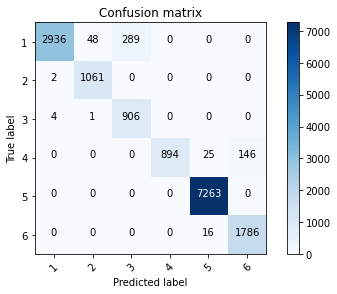

In [ ]:
plt.figure()
plot_confusion_matrix(results,classes=['1','2','3','4','5','6'],normalize=False,title='Confusion matrix')

**Visualization**

In [ ]:
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
def visualise(dataset,i) :
  plt.figure(figsize=(8,6))
  plt.imshow(dataset[:,:,i],cmap='jet')
  plt.title(f'Band-{i}',fontsize=14)
  plt.axis('off')
  plt.colorbar()
  plt.show()

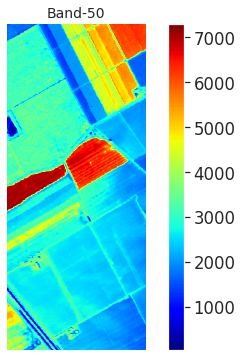

In [ ]:
visualise(sa_x1,50)

In [ ]:
def pixel_values(dataset,ground_truth) :
  df = pd.DataFrame()
  for i in range(dataset.shape[2]) :
    df = pd.concat([df,pd.DataFrame(dataset[:,:,i].ravel())],axis=1)
  df = pd.concat([df,pd.DataFrame(ground_truth.ravel())],axis=1)
  df.columns = [f'Band-{i}' for i in range(1,dataset.shape[2]+1)] + ['class']
  return df

In [ ]:
df = pixel_values(sa_x1,sa_y)

In [ ]:
df.head()

,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,Band-9,Band-10,Band-11,Band-12,Band-13,Band-14,Band-15,Band-16,Band-17,Band-18,Band-19,Band-20,Band-21,Band-22,Band-23,Band-24,Band-25,Band-26,Band-27,Band-28,Band-29,Band-30,Band-31,Band-32,Band-33,Band-34,Band-35,Band-36,Band-37,Band-38,Band-39,Band-40,...,Band-166,Band-167,Band-168,Band-169,Band-170,Band-171,Band-172,Band-173,Band-174,Band-175,Band-176,Band-177,Band-178,Band-179,Band-180,Band-181,Band-182,Band-183,Band-184,Band-185,Band-186,Band-187,Band-188,Band-189,Band-190,Band-191,Band-192,Band-193,Band-194,Band-195,Band-196,Band-197,Band-198,Band-199,Band-200,Band-201,Band-202,Band-203,Band-204,class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,1656,1670,1584,1643,1659,1619,1723,1785,1805,1822,1809,1790,1786,1770,1779,1737,1706,1709,1699,1663,1702,1682,1715,1682,1603,1615,1746,1784,1607,1757,...,424,429,437,409,391,378,364,354,329,340,344,337,321,310,291,284,272,254,240,250,216,220,192,162,173,149,134,129,138,104,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,1656,1670,1594,1613,1649,1619,1706,1767,1796,1805,1785,1798,1786,1770,1787,1745,1714,1741,1722,1656,1734,1722,1731,1728,1611,1623,1746,1777,1593,1724,...,429,440,439,409,389,382,370,360,331,342,347,340,323,305,298,282,275,254,240,248,211,225,192,162,180,147,136,131,138,111,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,1632,1636,1573,1613,1619,1591,1670,1704,1734,1763,1744,1748,1726,1721,1732,1698,1674,1701,1675,1610,1694,1682,1666,1651,1566,1565,1704,1735,1540,1691,...,417,422,420,395,377,368,358,351,324,332,335,325,318,302,283,276,265,251,240,236,223,216,188,162,176,142,125,129,129,106,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,1596,1603,1531,1562,1580,1526,1617,1668,1707,1704,1703,1698,1675,1680,1677,1651,1609,1620,1605,1571,1615,1609,1601,1604,1513,1499,1647,1660,1486,1620,...,401,408,411,387,365,361,346,339,310,316,325,318,304,285,276,267,260,239,223,234,201,209,176,161,164,136,127,123,131,100,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,1596,1558,1489,1532,1531,1508,1599,1632,1672,1687,1662,1664,1658,1639,1645,1612,1585,1596,1589,1525,1583,1569,1568,1566,1468,1478,1605,1612,1446,1574,...,394,410,397,376,356,351,340,332,303,318,321,315,297,287,271,265,246,230,216,226,194,202,178,150,167,127,125,120,122,96,83,105,83,48,75,50,24,9,17,0


In [ ]:
df.to_csv('salinas.csv',index=False)

In [ ]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 205), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

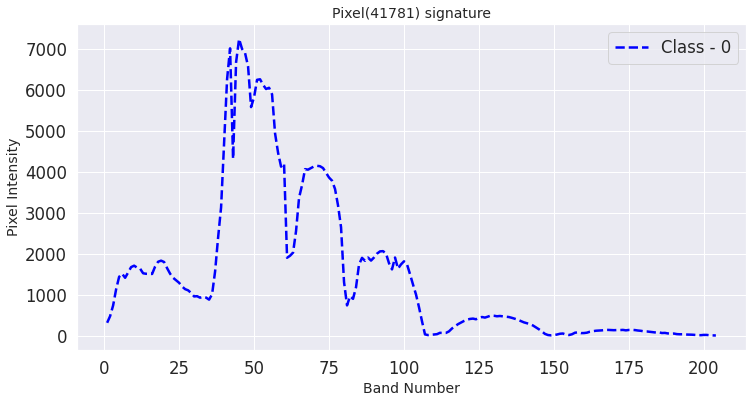

In [ ]:
plot_signature(df)

In [ ]:
PATCH_SIZE = 11
sa_x_padded = padWithZeros(sa_x2, PATCH_SIZE//2)

In [ ]:
sa_x2.shape

(512, 217, 30)

In [ ]:
sa_x_padded.shape

(522, 227, 30)

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]    
    return patch


**Visualization**


In [ ]:
checkpoint.restore('/content/drive/My Drive/Hyperspectral Few Shot/Model checkpoints/Training checkpoints/Salinas/New_train_5_way_salinas_25_128/ckpt-15')


In [ ]:
train_class_labels = [1,2,3,4,5,6,7,8,9,12]   
test_class_labels = [10,11,13,14,15,16]
height,width = 512,217
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(sa_y[i,j])  
        if target == 0 :     # avoid label 0
            continue
        elif target <= 5 :
            temp_list = []               
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)   # (9, 9, 20)  # ip_x.shape: (153, 153, 20)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')   #(1, 9, 9, 20, 1) 
            selected_classes = train_class_labels[0:5]
            support_labels = list(selected_classes)    # [1,2,3,4,5,6,7,8]
            support_patches = []
            for x in selected_classes :
              y = train_class_labels.index(int(x))
              support_imgs = train_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
            support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(25,im_height,im_width,im_depth,1)),dtype=tf.float32)
            query_patches = X_test_image  
            loss, mean_accuracy, mean_predictions = ProtoModel(support_patches, query_patches, support_labels, query_labels, 5, 5, 1/5,1,training=True)
            outputs[i][j] = tf.argmax(mean_predictions,axis=1) + 1         #1 is added since trained with lowering index 1
        elif target in train_class_labels[5:10]: 
            temp_list = []           
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)   # (9, 9, 20)  # ip_x.shape: (153, 153, 20)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')   #(1, 9, 9, 20, 1) 
            selected_classes = train_class_labels[5:10]
            support_labels = list(selected_classes)    # [1,2,3,4,5,6,7,8]
            support_patches = []
            for x in selected_classes :
              y = train_class_labels.index(x)
              support_imgs = train_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
            support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(25,im_height,im_width,im_depth,1)),dtype=tf.float32)
            query_patches = X_test_image  
            loss, mean_accuracy, mean_predictions = ProtoModel(support_patches, query_patches, support_labels, query_labels, 5, 5, 1/5,1,training=True)
            index = tf.argmax(mean_predictions,axis=1)
            if index < 4 :
              outputs[i][j] = index + 6        
            elif index == 4 :
              outputs[i][j] = index + 8        
        

In [ ]:
checkpoint.restore('/content/drive/My Drive/Hyperspectral Few Shot/Model checkpoints/Tuning checkpoints/Salinas/5_shot_updated/tuning_ckpts/New_tune_5_way_salinas_25_128/ckpt-7')

In [ ]:
train_class_labels = [1,2,3,4,5,6,7,8,9,12]   
test_class_labels = [10,11,13,14,15,16]
for i in range(height):
    for j in range(width):
        target = int(sa_y[i,j])    #ip_y.shape: (145, 145)
        if target == 0 :     # avoid label 0
            continue
        elif target in test_class_labels[0:3]:
            temp_list = []                   
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)   # (9, 9, 20)  # ip_x.shape: (153, 153, 20)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')   #(1, 9, 9, 20, 1) 
            selected_classes = test_class_labels[0:3]
            support_labels = list(selected_classes)    # [1,2,3,4,5,6,7,8]
            support_patches = []
            for x in selected_classes :
              y = test_class_labels.index(x)
              support_imgs = test_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
            support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(15,im_height,im_width,im_depth,1)),dtype=tf.float32)
            query_patches = X_test_image  
            loss, mean_accuracy, mean_predictions = ProtoModel(support_patches, query_patches, support_labels, query_labels, 5, 3, 1/3,1,training=True)
            index = tf.argmax(mean_predictions,axis=1)
            if index < 2 :
              outputs[i][j] = index + 10 
            elif index == 2 :
              outputs[i][j] = index + 11
        elif target in test_class_labels[3:6]:
            temp_list = [] 
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)   # (9, 9, 20)  # ip_x.shape: (153, 153, 20)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')   #(1, 9, 9, 20, 1) 
            selected_classes = test_class_labels[3:6]
            support_labels = list(selected_classes)    # [1,2,3,4,5,6,7,8]
            support_patches = []
            for x in selected_classes :
              y = test_class_labels.index(x)
              support_imgs = test_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
            support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(15,im_height,im_width,im_depth,1)),dtype=tf.float32)
            query_patches = X_test_image  
            loss, mean_accuracy, mean_predictions = ProtoModel(support_patches, query_patches, support_labels, query_labels, 5, 3, 1/3,1,training=True)
            outputs[i][j] = tf.argmax(mean_predictions,axis=1) + 14         #1 is added since trained with lowering index 1

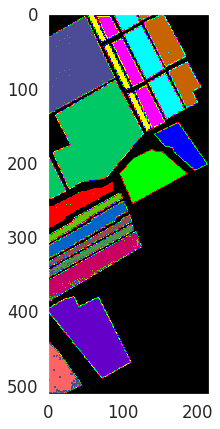

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize = (7,7)) 

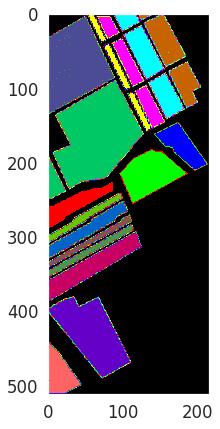

In [ ]:
ground_truth = spectral.imshow(classes = sa_y,figsize =(7,7))   # 0-16